### Import all required libraries

In [13]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io, color
from skimage.transform import resize
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

### Explore dataset garbage_classification_12_classes

In [4]:
dataset_path = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes')
classes = sorted(os.listdir(dataset_path))
print("Waste types:", classes)

Waste types: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [4]:
data = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    data.append({"Class": class_name, "Number of images": num_images})

df_counts = pd.DataFrame(data)
print(df_counts)
print("Total sum", "                 ", df_counts["Number of images"].sum())

          Class  Number of images
0       battery               945
1    biological               985
2   brown-glass               607
3     cardboard               891
4       clothes              5325
5   green-glass               629
6         metal               769
7         paper              1050
8       plastic               865
9         shoes              1977
10        trash               697
11  white-glass               775
Total sum                   15515


In [7]:
df_counts

Class  Number of images
0       battery               945
1    biological               985
2   brown-glass               607
3     cardboard               891
4       clothes              5325
5   green-glass               629
6         metal               769
7         paper              1050
8       plastic               865
9         shoes              1977
10        trash               697
11  white-glass               775

### Visualizations

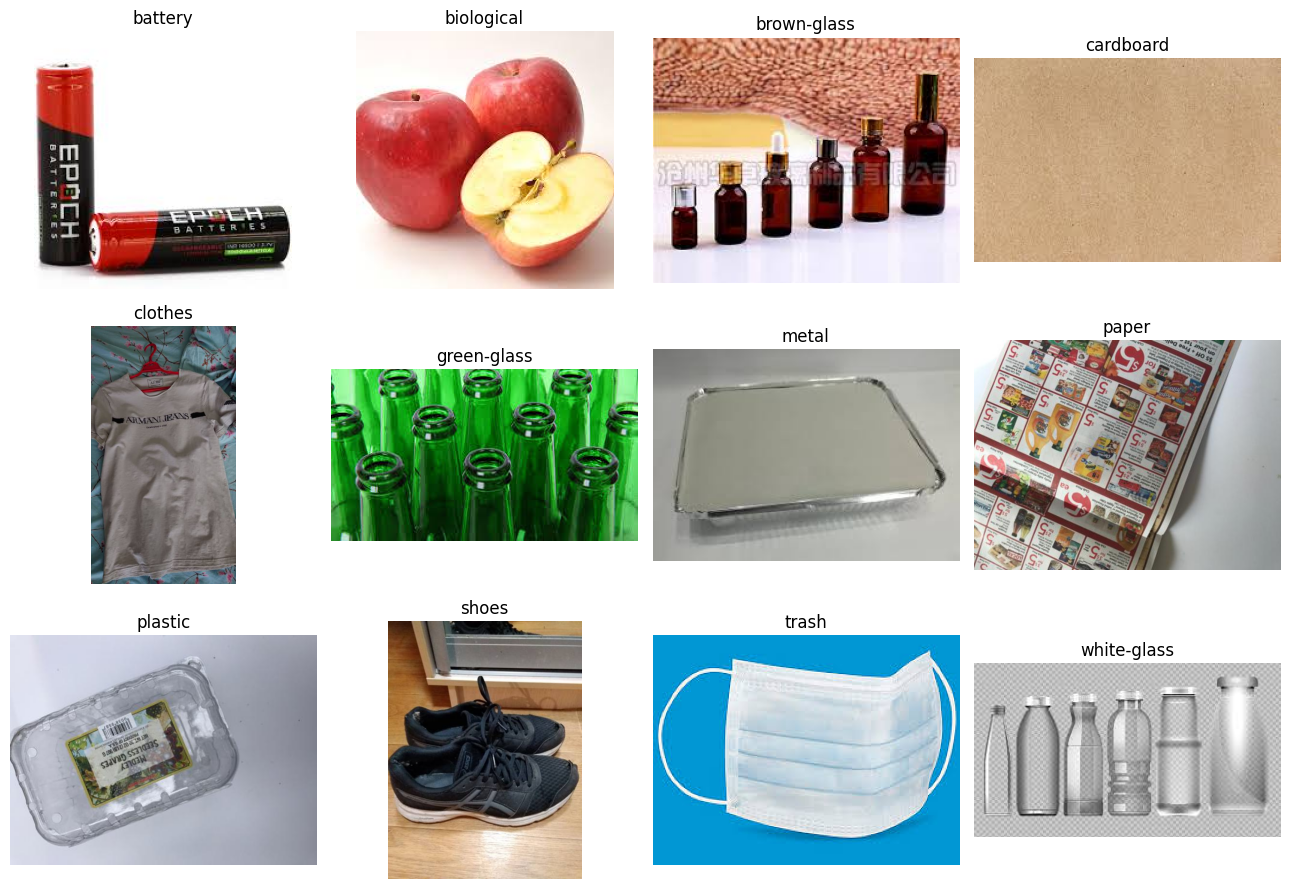

In [14]:
plt.figure(figsize=(13, 9))
for i, class_name in enumerate(classes[:12]):  
    class_path = os.path.join(dataset_path, class_name)
    all_images = os.listdir(class_path)
    img_name = random.choice(all_images)
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    plt.subplot(3, 4, i+1)  
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

    
plt.tight_layout()
plt.show()

In [9]:
# Open image with Pillow

# Select image
img = Image.open(os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes', 'battery', 'battery1.jpg'))

img_array = np.array(img)

# Dimensions
print("Size (width, high):", img.size)
print("channels:", len(img.getbands()))

# Visualize
img.show()  # Open image

Size (width, high): (280, 180)
channels: 3


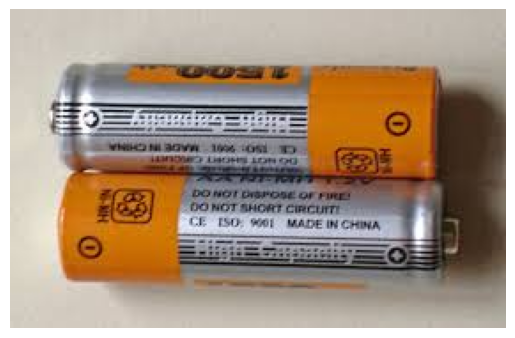

Shape (high, width, channels): (180, 280, 3)


In [16]:
# Open image with matplotlib.image
img = mpimg.imread(os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes', 'battery', 'battery1.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

# Dimensions
print("Shape (high, width, channels):", img.shape)

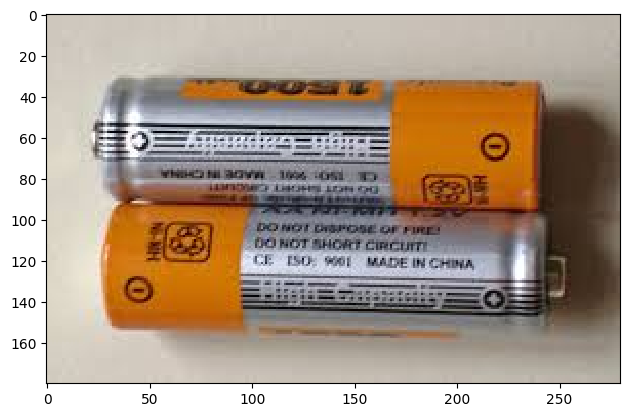

In [17]:
# Open image with scikit-image

img = io.imread(os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes', 'battery', 'battery1.jpg'))

img_gray = color.rgb2gray(img)

img_resized = resize(img, (224, 224))

io.imshow(img)
io.show()

### Create Dataframe

In [11]:
metadata = []

# Look for images and classes
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        
        # Open image and extract metadata
        with Image.open(img_path) as img:
            metadata.append({
                "image_path": img_path,
                "class": class_name,
                "width": img.width,
                "height": img.height,
                "channels": len(img.getbands()),
                "aspect_ratio": round(img.width / img.height, 2) # to see if the image is wider than tall, taller than wide or nearly square.
            })

df_metadata = pd.DataFrame(metadata)
df_metadata.head()

image_path    class  width  height  \
0  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    280     180   
1  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    220     165   
2  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    275     183   
3  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    275     183   
4  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  battery    224     224   

   channels  aspect_ratio  
0         3          1.56  
1         3          1.33  
2         3          1.50  
3         3          1.50  
4         3          1.00

### EDA

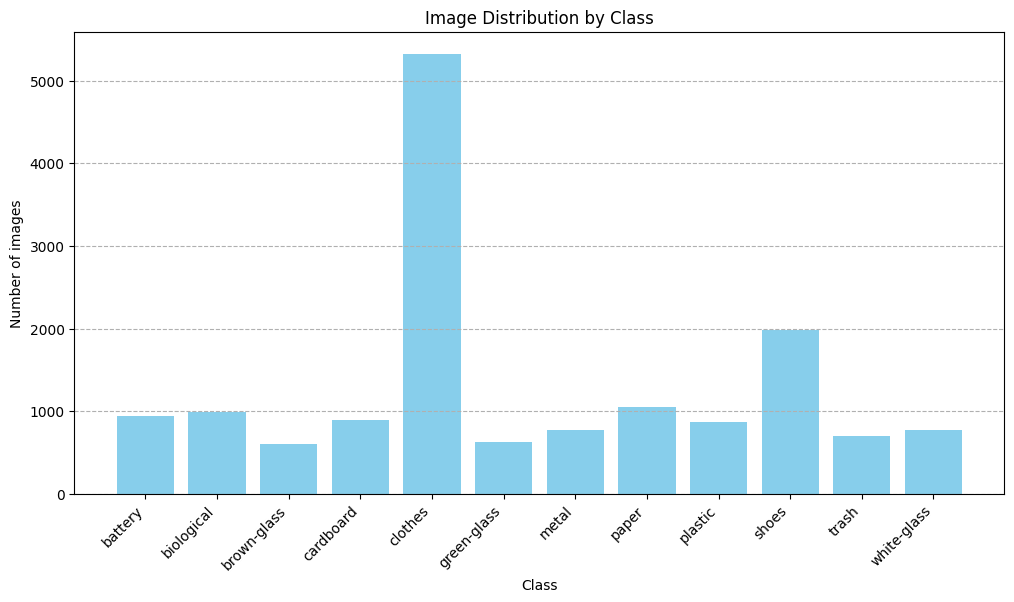

In [134]:
class_counts = df_counts["Number of images"]
plt.figure(figsize=(12, 6))
plt.bar(classes, class_counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Image Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--')
plt.show()

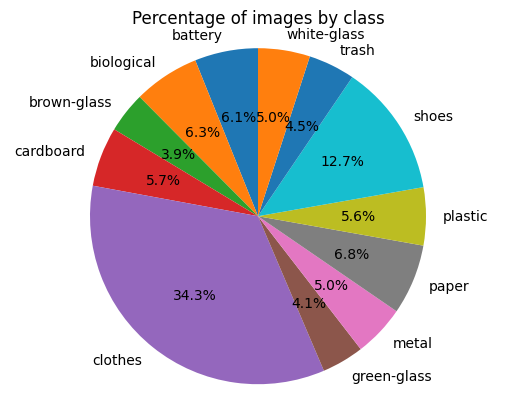

In [135]:
plt.pie(class_counts, labels=classes, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Percentage of images by class")
plt.show()

C:\Users\ruben\AppData\Local\Temp\ipykernel_12948\2858734669.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_palette = plt.cm.get_cmap('viridis', len(classes))


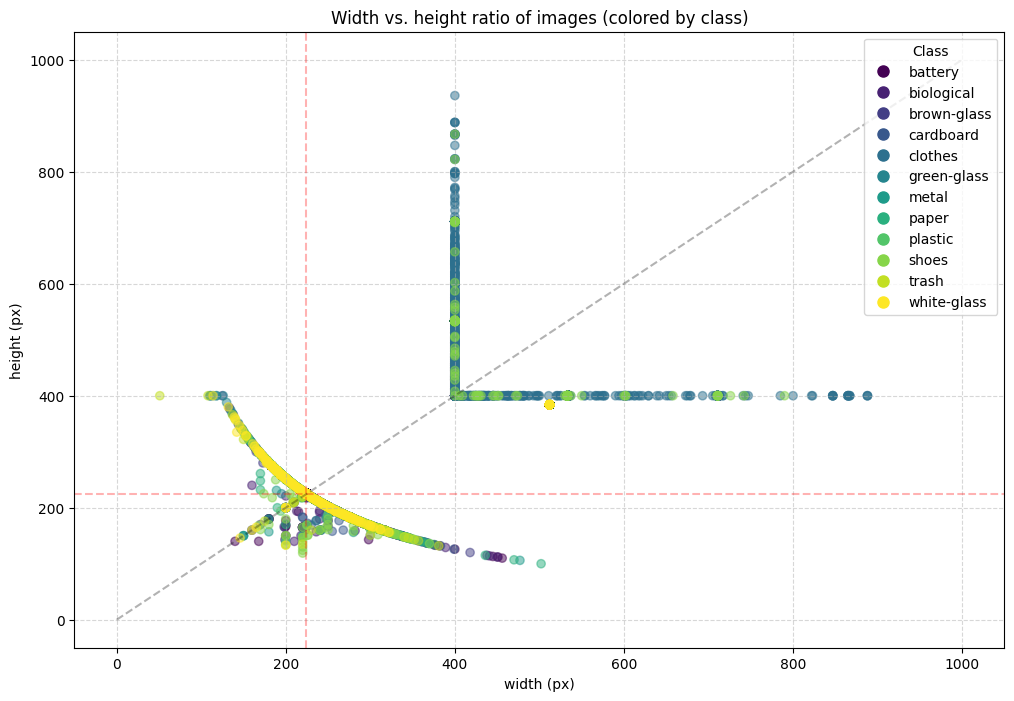

In [136]:
plt.figure(figsize=(12, 8))
custom_palette = plt.cm.get_cmap('viridis', len(classes))
plt.scatter(
    df_metadata["width"], 
    df_metadata["height"], 
    alpha=0.5,
    c = pd.factorize(df_metadata["class"])[0],  # Color by class
    cmap = custom_palette
)

plt.axhline(y=224, color='r', linestyle='--', alpha=0.3,)
plt.axvline(x=224, color='r', linestyle='--', alpha=0.3)
plt.plot([0, 1000], [0, 1000], 'k--', alpha=0.3, label='1:1') 

plt.title("Width vs. height ratio of images (colored by class)")
plt.xlabel("width (px)")
plt.ylabel("height (px)")
legend_elements = [plt.Line2D([0], [0], marker='o', color=custom_palette(i), linestyle='', markersize=8, label=class_name)
                   for i, class_name in enumerate(classes)]

plt.legend(handles=legend_elements, title="Class", loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

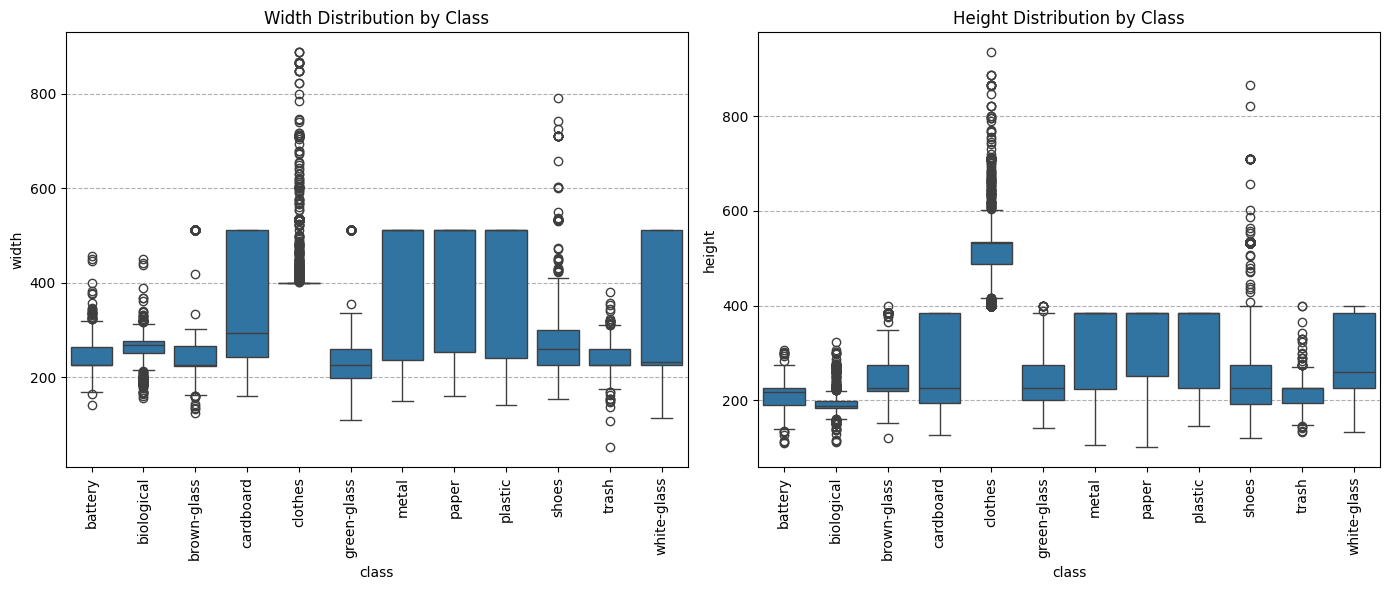

In [137]:
plt.figure(figsize=(14, 6))

# Boxplot for width
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='width', data=df_metadata)
plt.xticks(rotation=90)
plt.title("Width Distribution by Class")
plt.grid(axis='y', linestyle='--')

# Boxplot for high
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='height', data=df_metadata)
plt.xticks(rotation=90)
plt.title("Height Distribution by Class")
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

### Image resizing

In [ ]:
images = []
labels = []

# Target size for resizing images
IMG_SIZE = (224, 224)

# Mapping of class to numerical index
class_to_index = {class_name: i for i, class_name in enumerate(classes)}

# Resizing
for index, row in df_metadata.iterrows():
    img_path = row['image_path']
    class_name = row['class']

    with Image.open(img_path) as img:
        img = img.convert('RGB')  # Consistent Image Format
        img_resized = resize(np.array(img), IMG_SIZE, anti_aliasing=True).astype(np.float32)
        print(f"Range after resize for {img_path}: Min={img_resized.min()}, Max={img_resized.max()}") # Checking data already normalized
        images.append(img_resized)
        labels.append(class_to_index[class_name])

# Converting lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print("Total number of images uploaded:", len(images))
print("Total number of labels loaded:", len(labels))
print("Image format:", images[0].shape)
print("Label format:", labels.shape)
print("Example of label (class index):", labels[0])
print("Class corresponding to index 0:", classes[0])

Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery1.jpg: Min=0.0, Max=1.0
Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery10.jpg: Min=0.005875240545719862, Max=1.0
Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery100.jpg: Min=0.0, Max=1.0
Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery101.jpg: Min=0.0, Max=1.0
Range after resize for C:\Users\ruben\OneDrive\Escritorio\IRONHACK\final_project\datasets\garbage_classification_12_classes\garbage_classification\battery\battery102.jpg: Min=0.0, Max=1.0
Range after resize for C:\Users\ruben\OneDrive

### Dividing dataset into training, validation and test

In [139]:
# Split into training and validation/test (80% training).
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Divide the validation and test (10% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=len(classes))
y_val_encoded = to_categorical(y_val, num_classes=len(classes))
y_test_encoded = to_categorical(y_test, num_classes=len(classes))

print("Training set size:", X_train.shape)
print("Size of training labels:", y_train_encoded.shape)
print("Validation set size:", X_val.shape)
print("Size of validation tags:", y_val_encoded.shape)
print("Test set size:", X_test.shape)
print("Size of test labels:", y_test_encoded.shape)

Training set size: (12412, 224, 224, 3)
Size of training labels: (12412, 12)
Validation set size: (1551, 224, 224, 3)
Size of validation tags: (1551, 12)
Test set size: (1552, 224, 224, 3)
Size of test labels: (1552, 12)


### ResNet50 Model (pre-trained base model)

In [142]:
# Load the pre-trained base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model layers to prevent training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(500, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Show model architecture
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Apply ResNet50-specific preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
callbacks = [early_stopping, lr_scheduler]

# Training the model
epochs = 50
batch_size = 32

history = model.fit(
    X_train,
    y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
388/388 [==============================] - 579s 1s/step - loss: 2.0327 - accuracy: 0.3774 - val_loss: 1.8432 - val_accuracy: 0.4371 - lr: 1.0000e-04
Epoch 2/50
388/388 [==============================] - 573s 1s/step - loss: 1.6605 - accuracy: 0.4857 - val_loss: 2.1050 - val_accuracy: 0.4275 - lr: 1.0000e-04
Epoch 3/50
388/388 [==============================] - 7204s 19s/step - loss: 1.5398 - accuracy: 0.5193 - val_loss: 2.1679 - val_accuracy: 0.3282 - lr: 1.0000e-04
Epoch 4/50
388/388 [==============================] - 929s 2s/step - loss: 1.4723 - accuracy: 0.5393 - val_loss: 1.5814 - val_accuracy: 0.5035 - lr: 1.0000e-04
Epoch 5/50
388/388 [==============================] - 594s 2s/step - loss: 1.4156 - accuracy: 0.5483 - val_loss: 1.4375 - val_accuracy: 0.5693 - lr: 1.0000e-04
Epoch 6/50
388/388 [==============================] - 607s 2s/step - loss: 1.3723 - accuracy: 0.5651 - val_loss: 1.5206 - val_accuracy: 0.5416 - lr: 1.0000e-04
Epoch 7/50
388/388 [==================

### Evaluating model

In [ ]:
# Evaluate the model on the test
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Loss in the test: {loss:.4f}")
print(f"Accuracy in the test: {accuracy:.4f}")

In [ ]:
# Loss and accuracy visualization during the training model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

49/49 [==============================] - 54s 1s/step


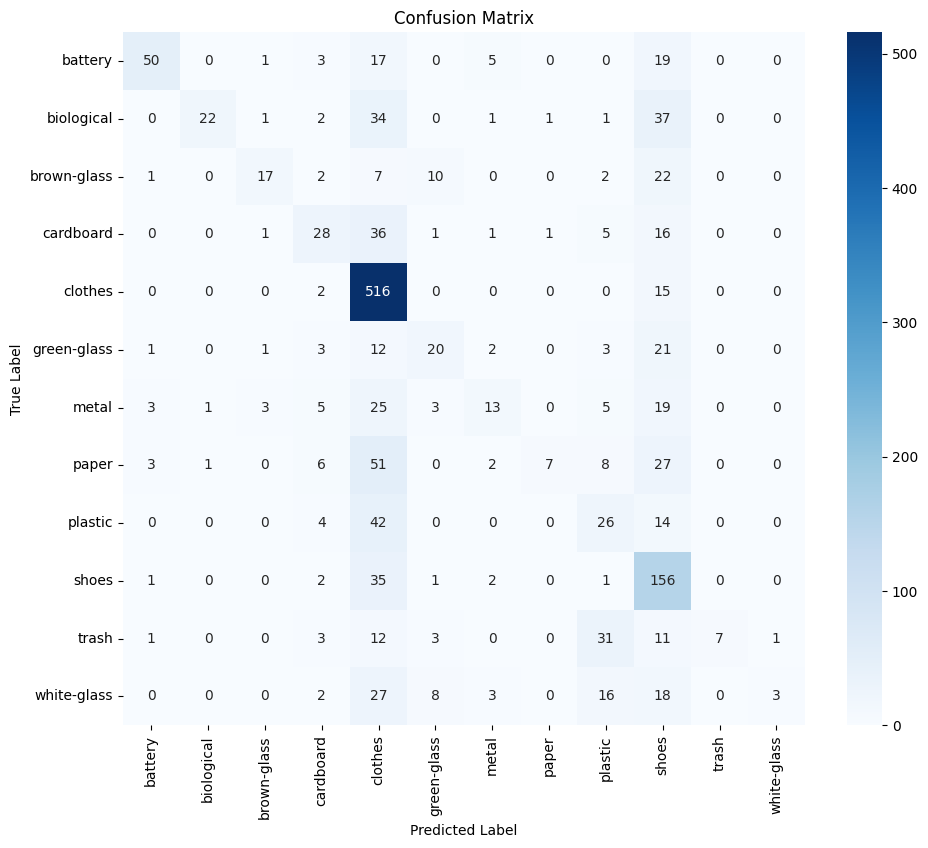

In [ ]:
predictions = model.predict(X_test)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(y_test_encoded, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(11, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

49/49 [==============================] - 67s 1s/step


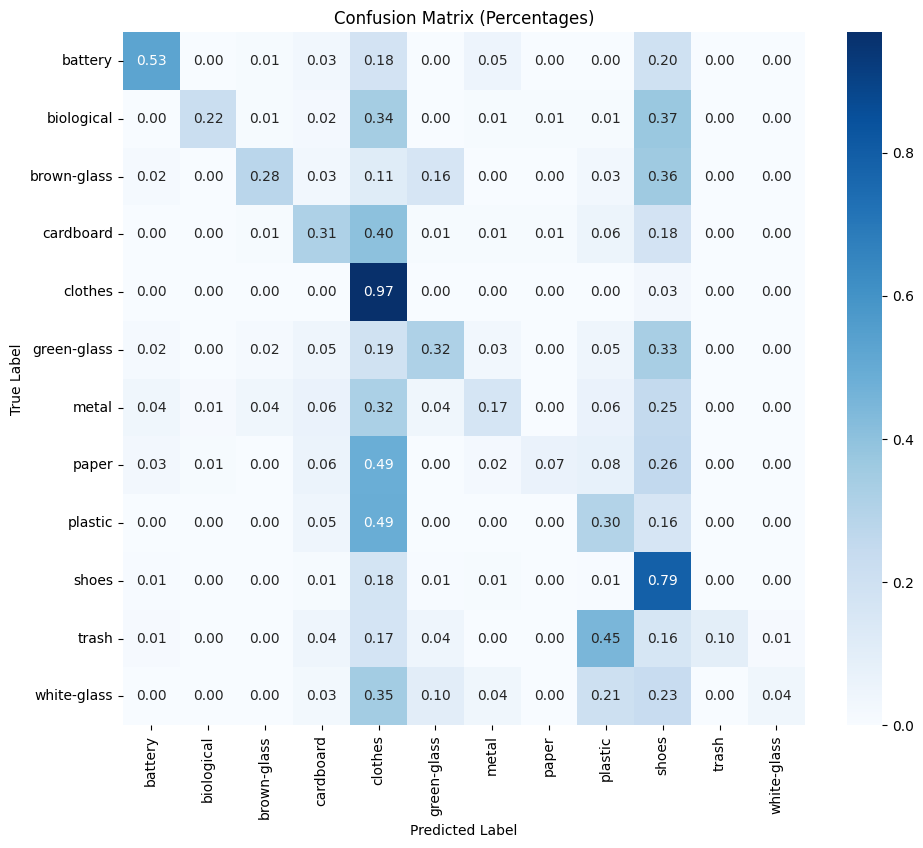

In [ ]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_encoded, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages)')
plt.show()

### Visualize possible image discrepancies between classes differences

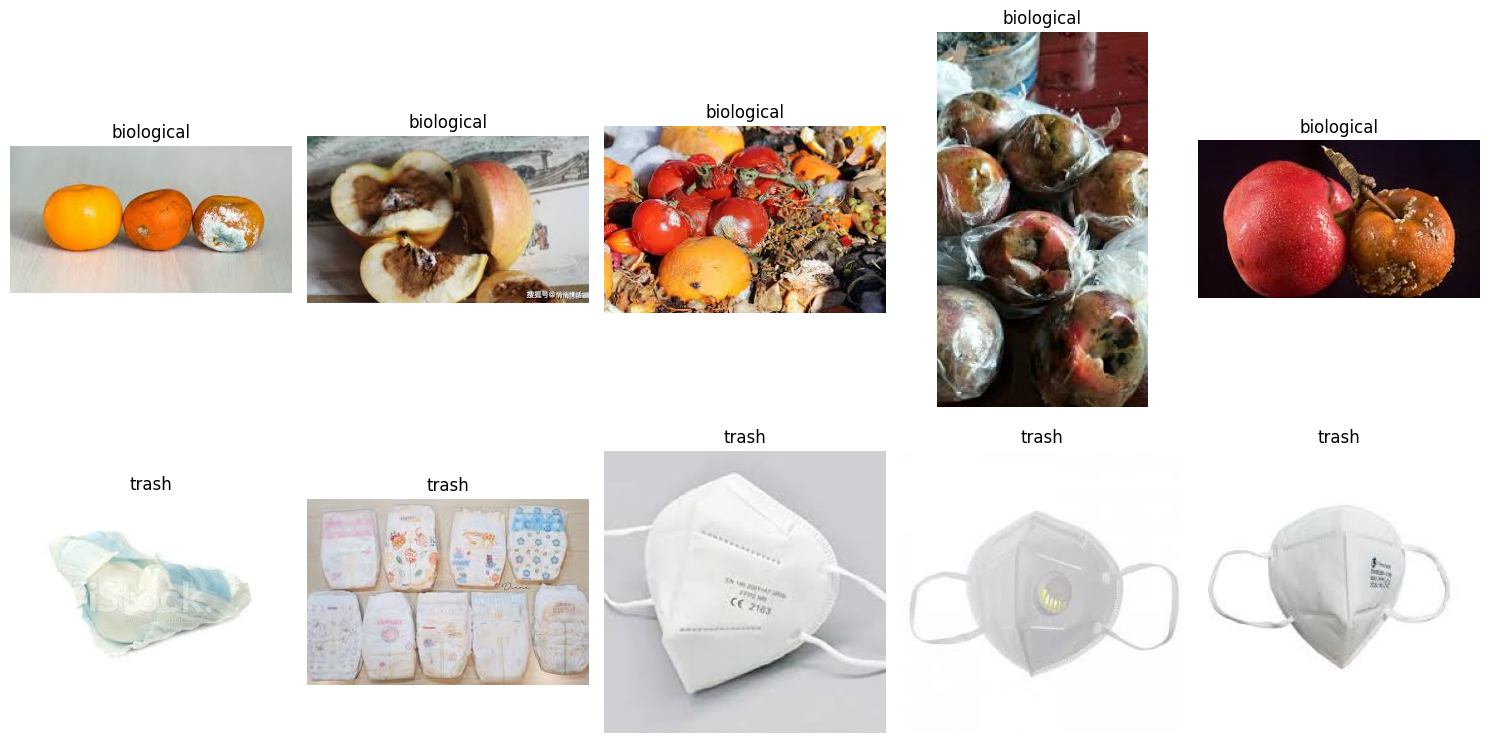

In [ ]:
classes_to_visualize = ["biological", "trash"]
num_images_per_class = 5  

plt.figure(figsize=(15, 8))

for i, class_name in enumerate(classes_to_visualize):
    class_path = os.path.join(dataset_path, class_name)
    all_images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))] 
    random_images = random.sample(all_images, num_images_per_class)
    for j, img_name in enumerate(random_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(len(classes_to_visualize), num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()